In [1]:
import gym
import numpy as np
from simple_agent import DLQAgent
from datetime import datetime
import sys
import json

In [2]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


/Users/boniface/opt/miniconda3/envs/drlnd/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
class Config:
    def __init__(self):
        self.num_episodes = 2000
        self.gamma = 0.99
        self.epsilon_start = 0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0
        self.tau = 1e-3
        self.memory_size = int(1e5)
        self.min_prioritization = 1e-4
        self.prioritization_exponent = 0.5
        self.prioritization_importance_sampling_start = 0.4
        self.prioritization_importance_sampling_end = 1
        self.batch_size = 64
        self.update_every = 4
        self.mlp_layers = (120, 84)
        self.learning_rate = 5e-4
        
        
    def as_dict(self):
        return self.__dict__

dlq_agent = DLQAgent(Config(), env.action_space.n, env.observation_space.shape[0])

In [4]:
def rolling_avg_scores(scores, window):
    if len(scores) <= window:
        return [np.mean(scores)]
    else:
        return [np.mean(scores[x:x+window]) for x in range(len(scores) - window + 1)]

def run(env, agent, num_episodes=1500):
    start_time = datetime.utcnow()
    scores = []
    health_checks = []
    for i_episode in range(num_episodes):
        state = env.reset()
        score = 0
        t_step = 0
        for t in range(1000):
            action = agent.act(state)                      # select an action
            next_state, reward, done, _ = env.step(action) # send the action to the environment
            score += reward                                # update the score
            agent.step(
                state, action, next_state, reward, done)   # update the agent
            state = next_state                             # roll over the state to next time step
            t_step += 1
            if done:                                       # exit loop if episode finished
                scores.append(score)
                break
        health_check = agent.health_check()
        health_checks.append(health_check)
        model1_loss, memory_max_prioritization, memory_size = health_check
        print("\rEpisode %d/%d | Max Average Score: %.2f | Model 1 loss: %.2f | Memory max prioritization: %.2f | Memory size: %d    " % (
            i_episode,
            num_episodes,
            max(rolling_avg_scores(scores, 20)),
            model1_loss,
            memory_max_prioritization,
            memory_size), end="")
        sys.stdout.flush()
        if rolling_avg_scores(scores,100)[-1] >= 200:
            break
    end_time = datetime.utcnow()
    return scores, end_time - start_time, health_checks

In [5]:
scores, run_timing, health_checks = run(env, dlq_agent, num_episodes=Config().num_episodes)
with open('training_log.txt', 'a') as file:
    file.write("Training run on %s \n" % datetime.utcnow().isoformat())
    file.write("Lasted %dmin%d \n" % (run_timing.seconds // 60, run_timing.seconds % 60))
    file.write(json.dumps(Config().as_dict(), indent=2))
    file.write("\nMax average score: %f\n\n" % max(rolling_avg_scores(scores, 20)))

Episode 860/2000 | Max Average Score: 242.21 | Model 1 loss: 2.40 | Memory max prioritization: 0.00 | Memory size: 100000      

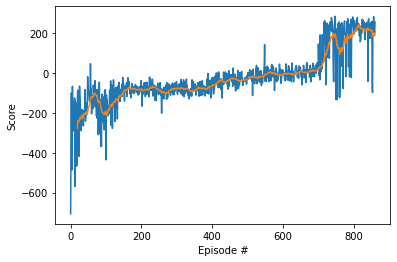

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(19, len(scores)), rolling_avg_scores(scores, 20))
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

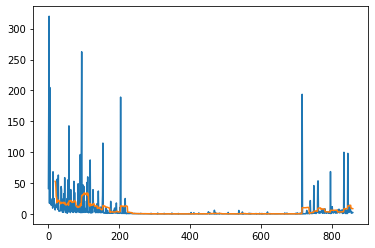

In [7]:
from operator import itemgetter
losses = [x for x in map(itemgetter(0), health_checks)]
plt.plot(np.arange(len(losses)), losses)
plt.plot(np.arange(19, len(losses)), rolling_avg_scores(losses, 20))
plt.show()